# Building a Simple GAN Architecture in Keras

## Introduction

In this lab, we will attempt to build a very simple Generative Adversarial Network for solving a toy problem. The GAN infrastructure shown in this lab can be applied to more complex problems including Computer vision and Image Analysis. GANs would take a long time to train even with simple image datasets like MNIST and CIFAR. You are encouraged to follow this experiment and try changing dataset and model architecture. For this lab, we will generate random sine curves and try to make our GAN learn and generate similar curves.

## Objectives
- Develop a simple GAN architecture using a generator and a discriminator
- Assess the performance of GAN using objective as well as subjective measures

## Import Libraries

Let's first import necessary libraries to build the GAN architecture using a generator and a discriminator. 

In [23]:
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from keras.models import Model
from keras.layers import Input, Reshape
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling1D, Conv1D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard

from keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG

## Generate Sample Data 
In order to keep our experiment simple and focus more at building a working GAN architecture, we will randonmly generate some sine curves. You can modify this function to collect data (e.g. images) from a larger dataset.

Here is the data sampling function:



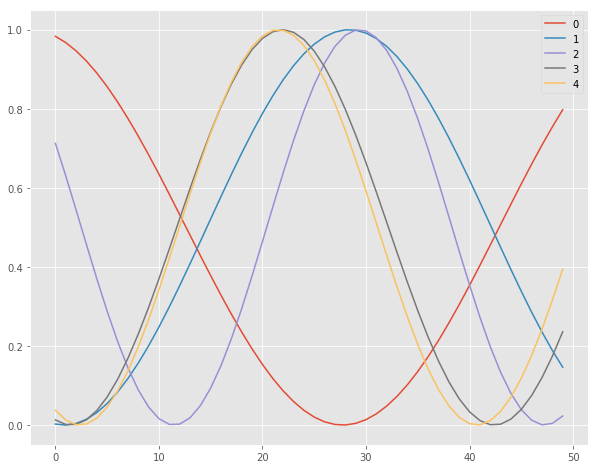

In [32]:
# Function for generating sine curves with a specified offset
def generate_data(n=10000, x_vals=np.arange(0, 5, .1), max_offset=100, mul_range=[1, 2]):
    vectors = []
    for i in range(n):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(
            np.sin(offset + x_vals * mul) / 2 + .5
        )
    return np.array(vectors)

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

# Generate 5 random curves using the function above
ax = pd.DataFrame(np.transpose(generate_data(5))).plot()


## Building the GAN
We will now attempt to build a GAN model that we will train on our sample data to generate new data from some noise source and a second model that will detect real data from generated data.

### Generator Model 
We will first create our generator model using simple dense layers activated by tanh (Hyperbolic Tangent) activation function. This model will input noise data and try to generate some sine curves from it. The training in the generator model will take place as a part of larger GAN setup. We use an SGD optimizer with a learning rate of .001. 

In [30]:
def generator(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    G.compile(loss='binary_crossentropy', optimizer=opt)
    return G, G_out

G_in = Input(shape=[10])
G, G_out = generator(G_in)
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________


Let's visualize our generator network. 

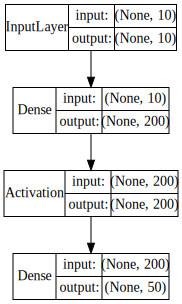

In [34]:
# Visualize the network 
SVG(model_to_dot(G, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

### Build the Discriminator

We will now create our discriminator model which would attempt to identify if the curve is real or generated by the generator model. This model will be trained directly with an Adam optimizer and a binary cross entropy loss measure. 

In [36]:
# Build the discriminator network 
def discriminator(D_in, lr=1e-3, drate=.25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    return D, D_out

D_in = Input(shape=[50])
D, D_out = discriminator(D_in)
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 50)                0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 50, 1)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 46, 50)            300       
_________________________________________________________________
dropout_2 (Dropout)          (None, 46, 50)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2300)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                115050    
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 102       
Total para

Let's visualize our discriminator network just like we did above.

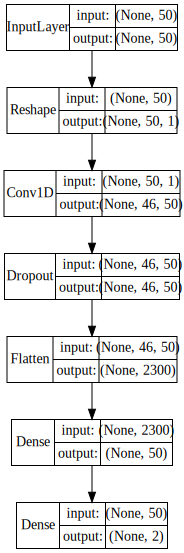

In [37]:
# Visualize the network 
SVG(model_to_dot(D, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

### Connecting Generator and Discriminator

We will now chain the generator and discriminator models into a complete GAN architecture. The final network will train the generator while we stop training the discriminator. We will achieve this by creating a freezing function that we will apply on the discriminative model each time we train the GAN, in order to train the generative model. The freezing function will define weather a model is trainable or not as shown below:

In [9]:
# Set the trainability of a given model
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_1 (Model)              (None, 50)                12250     
_________________________________________________________________
model_2 (Model)              (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


Now we can go ahead build our final GAN architecture as shown below:

In [43]:
# Build the final GAN architecture 
def build_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([10])
GAN, GAN_out = build_gan(GAN_in, G, D)
GAN.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 10)                0         
_________________________________________________________________
model_4 (Model)              (None, 50)                12250     
_________________________________________________________________
model_5 (Model)              (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


## Training the GAN

With our GAN architecture in place, we can train the models by alternately training the discriminator and the chained models.

### Pre-training

We will generate some fake and real data and pre-train the discriminator for a single epoch before starting the GAN. This also let us check if our compiled models correctly runs on our real and noisy input.

In [44]:
# Generate data for pre-training 
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1
    return X, y

# Pretrain the discriminator network for a single epoch
def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    ep = 1
    X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
    set_trainability(D, True)
    D.fit(X, y, epochs=ep, batch_size=batch_size)

pretrain(G, D)

Epoch 1/1
20000/20000 [==============================] - 2s 96us/step - loss: 6.8818e-05


### Train the GAN with alternating training steps

We can now train our GAN by alternating the training of the Discriminator and the training of the chained GAN model while keeping Discriminator’s weights unchanged. We will capture the loss values after 50 epochs during training. 

__Note:__ With 500 epochs , the training will take about 20 minutes on a regular computer. You can increase the number of epochs to improve the results. 

In [45]:
# Sample some noise from a uniform distribution 
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1
    return X, y

def train(GAN, G, D, epochs=500, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    # initialize loss arrays
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim)
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
    return d_loss, g_loss

d_loss, g_loss = train(GAN, G, D, verbose=True)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Epoch #50: Generative Loss: 2.337773561477661, Discriminative Loss: 0.7683719992637634
Epoch #100: Generative Loss: 3.876081943511963, Discriminative Loss: 0.11672800034284592
Epoch #150: Generative Loss: 4.921514987945557, Discriminative Loss: 0.05583527684211731
Epoch #200: Generative Loss: 3.83070969581604, Discriminative Loss: 0.11579655855894089
Epoch #250: Generative Loss: 3.7273592948913574, Discriminative Loss: 0.0686127319931984
Epoch #300: Generative Loss: 4.190981864929199, Discriminative Loss: 0.0657963901758194
Epoch #350: Generative Loss: 3.111837863922119, Discriminative Loss: 0.15060611069202423
Epoch #400: Generative Loss: 3.771789789199829, Discriminative Loss: 0.15108631551265717
Epoch #450: Generative Loss: 3.234790325164795, Discriminative Loss: 0.08329550176858902
Epoch #500: Generative Loss: 3.6005547046661377, Discriminative Loss: 0.04755375161767006


## Measure the Loss

We will now plot the loss curves for both generator (`g_loss`) and discriminator (`d_loss`) to see how well the network converges. 

Text(0,0.5,'Loss')

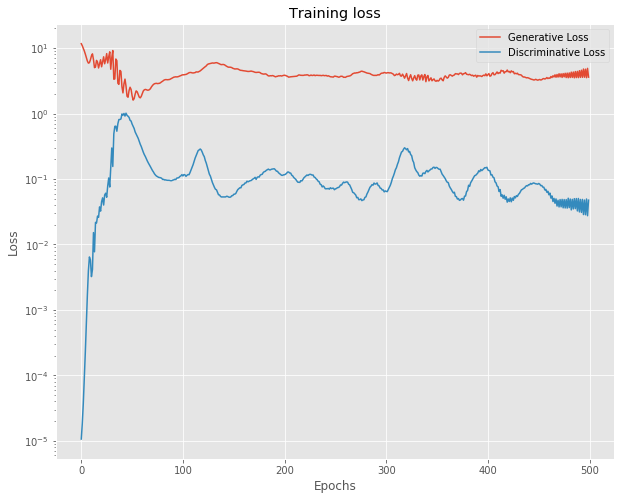

In [46]:
ax = pd.DataFrame({
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }).plot(title='Training loss', logy=True)

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

The loss graph above demonstrates that both networks are competing with each other in attempt to produce a better performance than the other. During training phases, either the generator or the discriminator is lowering its loss relative to a loss gain on the other side.

In must be kept in mind at this stage that the loss values alone are not a good measure of assessing a GAN's generative performance. We do not want our network to converge too fast which may mean that the network has not learned fully and both models are simply trying to cheat each other, without any real success. The amount of times each model got better relatively to the other could be indicative of how well the network is performing. 

## Final Results 

Let's now visualize some generated sine curves from our generator. 

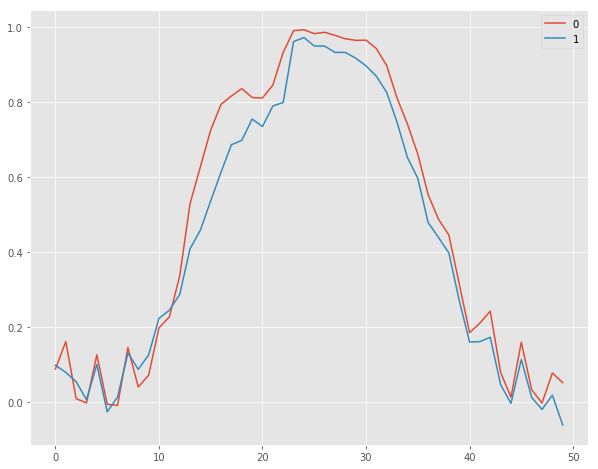

In [47]:
# View generated curves
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()

### Apply Rolling Means smoothing 

We can see above that we do not a perfect sine curve. Referring back to our section on time-series analysis, we can consider applying rolling averages to these curves as shown below:

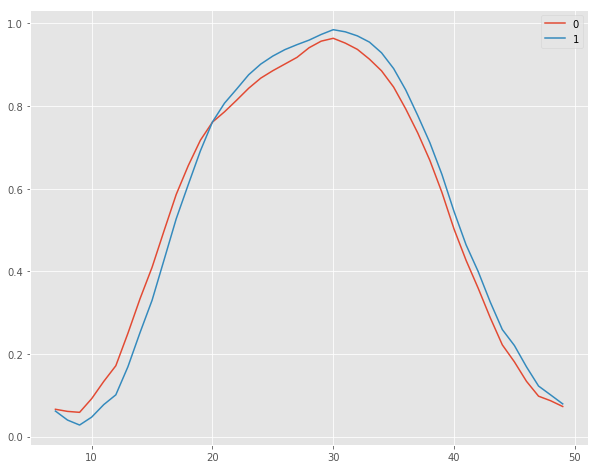

In [53]:
# Apply rolling means to sine curves
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(8).mean()[5:].plot()

So there we have it. Our generated sine curve. We have applied rolling average to the curve to make it look a bit more sine-like In reality, we would need longer training period, and model optimization techniques to get even better results.  We can also experiment to see that the generator model produces similar output curves for different noise inputs. Our simple GAN simply prefers refining something it already knows.

## Additional Resources 

training GANs could be a complicated and time consuming task. GANs are known to break very easy, get stuck in local minima or , in worst case scenarios, generator and discrimintaor can get engaged in a never ending battle. Also, training GANs require us to either use GPU based processing or a cluster environment. 

Our simple example above is supposed to help you understand how a GAN is structured and how the training stage is schedules. You are encouraged to improve this experiment with a more realistic dataset to produce meaningful outputs. Following links provide you with a few real experiments done with keras, under a similar framework as shown above. 

- [A Beginner's guide to GANs](https://skymind.ai/wiki/generative-adversarial-network-gan) - An excellent introduction to GANs with keras with links to practical examples. 
- [GAN by Example using Keras on Tensorflow Backend](https://towardsdatascience.com/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0) - A deep convolutional GAN
- [GAN with Keras: Application to Image Deblurring](https://blog.sicara.com/keras-generative-adversarial-networks-image-deblurring-45e3ab6977b5) - Sharpening blurred images

## Summary 

Creating GANs involve creating 3 models as we saw above and defining how to perform a training stage. Depending on the task you may want to achieve, more tuning and computations will be required as data gets complicated. GANs are  very powerful generators but may be very hard to tune correctly especially since it is hard to measure their performance. The loss is not necessarily a good indicator of performance, instead the most reliable way to check if their output makes sense subjectively. 